### imports

In [1]:
#importing things
import pandas as pd
import numpy as np
import csv
import pylab as pl
import matplotlib.pyplot as plt
import copy
import scipy
from collections import OrderedDict
import seaborn as sns
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.special import comb
from matplotlib.colors import LogNorm
from matplotlib.patches import Patch
import matplotlib as mpl
import matplotlib.lines as lines

plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams.update({'xtick.labelsize': 7})
plt.rcParams.update({'ytick.labelsize': 7})
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['axes.linewidth'] = 0.5

### Load first order coefficients

In [2]:
h1_linear = pd.read_table('../../CR6261/Epistasis_linear_models/model_coefs/H1_4order_biochem.txt',names=['Term','H1_Effect','H1_SE','H1_95CI_low','H1_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
h1_fil = h1_linear[~h1_linear["Term"].str.contains(',')]
H9_linear = pd.read_table('../../CR6261/Epistasis_linear_models/model_coefs/H9_4order_biochem.txt',names=['Term','H9_Effect','H9_SE','H9_95CI_low','H9_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
H9_fil = H9_linear[~H9_linear["Term"].str.contains(',')]
first_order = pd.merge(h1_fil,H9_fil,on='Term',how='outer')
first_order['Term'] = first_order['Term'].replace({'1':'29','2':'35','3':'65','4':'66','5':'69','6':'82','7':'83','8':'84','9':'85','10':'87','11':'112.1'})
first_order.head()

,Term,H1_Effect,H1_SE,H1_95CI_low,H1_95CI_hi,H9_Effect,H9_SE,H9_95CI_low,H9_95CI_hi
0,29,0.807303,0.079287,1.702347e-23,0.495627,-0.234604,0.134466,0.081277,-0.763246
1,35,0.573613,0.086393,4.576728e-11,0.234003,0.410971,0.136966,0.002747,-0.127500
2,65,0.073511,0.079230,3.536715e-01,-0.237941,-0.054637,0.134341,0.684290,-0.582787
3,66,-0.054930,0.079087,4.874615e-01,-0.365822,0.081023,0.134359,0.546595,-0.447200
4,69,0.024557,0.080114,7.592471e-01,-0.290368,-0.131260,0.136481,0.336361,-0.667824


### Load structure with selected regions and mutated residues

In [3]:
antigen="H9"
#import stuff
from pymol import cmd
#load pdb
if antigen == "H1" or "H9":
    cmd.fetch('3GBN') #1918 H1N1 with fab
    cmd.hide('everything')
    ##########################
    #rename chains and sugars for individual selections
    #H5 chains
    monoA1 = cmd.select('monoA1', 'chain A')
    monoA2 = cmd.select('monoA2', 'chain B')
    HA = cmd.select('HA', 'chain A or chain B')
    #Fab CR9114 chains
    HC = cmd.select('HC', 'chain H')
    LC = cmd.select('LC', 'chain L')
    Ab = cmd.select('Ab', 'chain H or chain L')
    #sugars
    sugars = cmd.select('sugars', 'resn EDO or resn NAG or resn GOL')
    #create selections for mutated residues
    mut1 = cmd.select('mut29',('chain H and resi 28'))
    mut2 = cmd.select('mut35',('chain H and resi 30'))
    mut3 = cmd.select('mut65',('chain H and resi 57'))
    mut4 = cmd.select('mut66',('chain H and resi 58'))
    mut5 = cmd.select('mut69',('chain H and resi 61'))
    mut6 = cmd.select('mut82',('chain H and resi 73'))
    mut7 = cmd.select('mut83',('chain H and resi 74'))
    mut8 = cmd.select('mut84',('chain H and resi 75'))
    mut9 = cmd.select('mut85',('chain H and resi 76'))
    mut10 = cmd.select('mut87',('chain H and resi 78'))
    mut11 = cmd.select('mut112.1',('chain H and resi 100'))
    mutations = ['mut29','mut35','mut65','mut66','mut69','mut82','mut83','mut84','mut85','mut87','mut112.1']

 PyMOL not running, entering library mode (experimental)


### Count HA residues with atoms within 6 Angstroms of an atom in each CR-9114 mutated residue

In [4]:
#make a list of positions within a certain distance of other things
#################################################
#intermolecular interaction distances
#hydrogen bond: 4 A
#salt bridge: 4 A
#vWaals: 6 A
#resolution of structure is 1.71 A, so call potential interactions as within 6 A
#################################################
#import things
from pymol import *
distance = 6
neighbors_summary=[]
region='HA'
for mutant in mutations:
    print(mutant)
    focal='%s' % mutant
    selection='br. pol. in ('+str(region)+')within %s of (' % distance +str(focal)+')'
    nearby = cmd.select('nearby',selection) #change focal point here
#print list of these residues
    stored.chains = []
    cmd.iterate('nearby', 'stored.chains.append(chain+resi+resn)')
#################################################
#export to csv file
    contacts=[]
    count = 0
    for i in stored.chains:
        if i not in contacts:
            count = count + 1
            contacts.append(i)
    if region=='HC':
        count = count - 1 #dont want to count the residue of interest
    else:
        count = count
    neighbors_summary.append(count)
    print("There are "+str(count)+" residues with atoms within %s A of " % distance +str(mutant)+" in "+str(region))
    print(contacts)
    import csv
    with open('structure_output/CR6261/CR6261_contacts/%s_residues_near%s.txt' %(antigen,mutant), 'w') as f:
        for item in contacts:
            f.write("%s\n" % item)
print(neighbors_summary)
first_order['contacts_%s' % antigen]=neighbors_summary

mut29
There are 2 residues with atoms within 6 A of mut29 in HA
['B53ASN', 'B56ILE']
mut35
There are 3 residues with atoms within 6 A of mut35 in HA
['B45ILE', 'B49THR', 'B53ASN']
mut65
There are 0 residues with atoms within 6 A of mut65 in HA
[]
mut66
There are 0 residues with atoms within 6 A of mut66 in HA
[]
mut69
There are 0 residues with atoms within 6 A of mut69 in HA
[]
mut82
There are 0 residues with atoms within 6 A of mut82 in HA
[]
mut83
There are 8 residues with atoms within 6 A of mut83 in HA
['A40VAL', 'A41ASN', 'A42LEU', 'A291SER', 'A292LEU', 'A293PRO', 'B52VAL', 'B56ILE']
mut84
There are 1 residues with atoms within 6 A of mut84 in HA
['A291SER']
mut85
There are 0 residues with atoms within 6 A of mut85 in HA
[]
mut87
There are 0 residues with atoms within 6 A of mut87 in HA
[]
mut112.1
There are 0 residues with atoms within 6 A of mut112.1 in HA
[]
[2, 3, 0, 0, 0, 0, 8, 1, 0, 0, 0]


### Figure 3c

In [5]:
first_order.to_csv('structure_output/CR6261/firstorder_summary%s.csv'% antigen,index=False)
first_order = pd.DataFrame(pd.read_csv('structure_output/CR6261/firstorder_summary%s.csv'% antigen,delimiter=','))
first_order.replace(to_replace=10, value=1.2,inplace=True)
upper = max(list(first_order['H1_Effect']))
lowerh1 = min(list(first_order['H1_Effect']))
if min(list(first_order['H9_Effect'])) < lowerh1:
    lower= min(list(first_order['H9_Effect']))
else:
    lower=lowerh1

In [6]:
#print commands for mapping onto pymol structure
print('stored.newB='+str(list(first_order["%s_Effect" % antigen]))+'\nalter 6261m, b=0.0\nalter 6261m and n. CA, b=stored.newB.pop(0)\nalphatoall *,b\nspectrum b, blue_white_red, 6261m, minimum=-1.5, maximum=1.5')

stored.newB=[-0.2346035324511755, 0.4109710837709832, -0.054637486612941266, 0.08102278344817282, -0.13125966509251352, -0.0653036461794283, -0.2945171971599199, 0.14817135034327875, -0.09488560160189052, -0.07782193213292521, 0.0354402010911965]
alter 9114m, b=0.0
alter 9114m and n. CA, b=stored.newB.pop(0)
alphatoall *,b
spectrum b, blue_white_red, 9114m, minimum=-0.2945171971599199, maximum=1.34160851322306


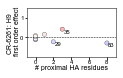

In [6]:
#H1 scatter
%matplotlib inline
import matplotlib as mpl
import matplotlib.cm as cm
plt.rcParams['lines.markeredgewidth'] = 0.1
plt.rcParams['scatter.edgecolors'] = 'black'
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(1.6,0.9))
plt.ylim(-1.0,1.5)
plt.xlim(-1,9)
x_locator = FixedLocator([0,2,4,6,8])
ax.xaxis.set_major_locator(x_locator)
ax.set_xticklabels(['0','2','4','6','8'])
plt.tick_params(labelsize=6,length=2.5,pad=0.5)
y_locator = FixedLocator([0,1])
ax.yaxis.set_major_locator(y_locator)
ax.set_yticklabels(['0','1'])
norm = mpl.colors.Normalize(vmin=-1.5, vmax=1.5)
cmap = cm.get_cmap("bwr")
x=first_order['contacts_%s' % antigen]
y=first_order['%s_Effect' % antigen]
p1=sns.scatterplot(x=x,
            y=y,
            data=first_order,
            palette="bwr",
            hue_norm=(-1.5,1.5),
            x_jitter=True,
            marker='o',
            edgecolor='black',
            linewidth=0.25,
            size=4,
            hue='%s_Effect' % antigen)


# Loop over the points to force the edge colors
for i,thisbar in enumerate(p1.patches):
    # Set a different hatch for each bar
    thisbar.set_edgecolor('black')
#sort dataframe to only label outliers
first_order_s = first_order.iloc[(-first_order['%s_Effect' % antigen].abs()).argsort()].reset_index(drop=True)
lim=3
for line in range(0,lim):
    if antigen=="H9":
        ax.text(first_order_s.contacts_H9[line]+0.5, first_order_s.H9_Effect[line]-0.2, int(first_order_s.Term[line]), horizontalalignment='center', fontsize=6, color='black')
    elif antigen=="H1":
        ax.text(first_order_s.contacts_H1[line]+0.5, first_order_s.H1_Effect[line]-0.2, int(first_order_s.Term[line]), horizontalalignment='center', fontsize=6, color='black')


#plt.title('%s' % antigen,fontsize=8,weight='bold')
plt.xlabel('# proximal HA residues',fontsize=7 ,labelpad = 0)
plt.legend([],[], frameon=False)

#plt.legend(loc="upper center", bbox_to_anchor=(1.1, 1.1), ncol=1, fontsize=7,markerscale=0.5)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.ylabel('CR-6261: %s \n first order effect' % antigen,fontsize=7,labelpad=0)
plt.savefig('images/6261_%s_linear_contacts.png' % antigen, transparent=True, dpi=600,bbox_inches='tight')

### Figure 3f

In [7]:
model = "biochem"
plotting = "pairwise"
#import kl second order effects from second order model
mut_names = ['30','35','36','57','64','65','66','79','82','83','84','85','92','95','103','113']
if antigen == "H1":
    h1 = pd.read_table('../../CR6261/Epistasis_linear_models/model_coefs/H1_4order_biochem.txt',names=['Term','H1_Effect','H1_SE','H1_95CI_low','H1_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
    h1['order'] = h1[['Term']].applymap(lambda x: str.count(x, ',')+1)
    h1_pairwise = h1[h1['order']==2]
    h1_pairwise[['Mutation 1','Mutation 2']] = h1_pairwise.Term.str.split(",",expand=True)
    toplot = pd.DataFrame()
    toplot = h1_pairwise[['Mutation 1','Mutation 2','H1_Effect','H1_SE','H1_95CI_low','H1_95CI_hi']].copy()
    toplot['Mutation 1'] = toplot['Mutation 1'].replace({'1':'mut29','2':'mut35','3':'mut65','4':'mut66','5':'mut69','6':'mut82','7':'mut83','8':'mut84','9':'mut85','10':'mut87','11':'mut112.1'})
    toplot['Mutation 2'] = toplot['Mutation 2'].replace({'1':'mut29','2':'mut35','3':'mut65','4':'mut66','5':'mut69','6':'mut82','7':'mut83','8':'mut84','9':'mut85','10':'mut87','11':'mut112.1'})
    mask = (toplot['H1_95CI_low'] <= 0) & (toplot['H1_95CI_hi'] >=0)
    toplot['H1_Effect'][mask] = 0
elif antigen == "H9":
    H9 = pd.read_table('../../CR6261/Epistasis_linear_models/model_coefs/H9_4order_biochem.txt',names=['Term','H9_Effect','H9_SE','pval','H9_95CI_low','H9_95CI_hi'],skiprows=[0,1,2,3],index_col=False)
    H9['order'] = H9[['Term']].applymap(lambda x: str.count(x, ',')+1)
    H9_pairwise = H9[H9['order']==2]
    H9_pairwise[['Mutation 1','Mutation 2']] = H9_pairwise.Term.str.split(",",expand=True)
    toplot = pd.DataFrame()
    toplot = H9_pairwise[['Mutation 1','Mutation 2','H9_Effect','H9_SE','H9_95CI_low','H9_95CI_hi']].copy()
    toplot['Mutation 1'] = toplot['Mutation 1'].replace({'1':'mut29','2':'mut35','3':'mut65','4':'mut66','5':'mut69','6':'mut82','7':'mut83','8':'mut84','9':'mut85','10':'mut87','11':'mut112.1'})
    toplot['Mutation 2'] = toplot['Mutation 2'].replace({'1':'mut29','2':'mut35','3':'mut65','4':'mut66','5':'mut69','6':'mut82','7':'mut83','8':'mut84','9':'mut85','10':'mut87','11':'mut112.1'})
    mask = (toplot['H9_95CI_low'] <= 0) & (toplot['H9_95CI_hi'] >=0)
    toplot['H9_Effect'][mask] = 0

/Users/angelaphillips/opt/anaconda3/envs/pymol_v2/lib/python3.7/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/Users/angelaphillips/.local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Measure distance between alpha carbons

In [8]:
distance_log=[]
loc_muta = list(toplot['Mutation 1'])
loc_mutb = list(toplot['Mutation 2'])
epistasis = list(toplot['%s_Effect' % antigen])
labels=[]
for l in range(len(loc_muta)):
    var1=loc_muta[l]
    var2=loc_mutb[l]
    label = str(var1[3:])+','+str(var2[3:])
    labels.append(label)
    distance=cmd.distance(None, "%s and n. CA"%var1, "%s and n. CA"%var2) #distance between alpha carbons
    distance_log.append(distance)
df_toplot=pd.DataFrame()
df_toplot['labels']=labels
df_toplot['distance']=distance_log
df_toplot['epistasis']= epistasis
df_toplot.dropna(inplace=True)
s = df_toplot.sort_values(by='epistasis',ascending=False)
s.to_csv('structure_output/CR6261/2ndorder_summary%s.csv'% antigen,index=False)

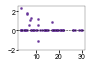

In [9]:
#sort dataframe to only label outliers
df_toplot_s = df_toplot.iloc[(-df_toplot['epistasis'].abs()).argsort()].reset_index(drop=True)

#number of outliers to label
if antigen=="H1":
    spot = "darksalmon"
    edge = "maroon"
elif antigen=="H9":
    spot = "rebeccapurple"
    edge = "rebeccapurple"
lim = 5
%matplotlib inline
import matplotlib as mpl
plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.25
fig, ax = plt.subplots(figsize=(1.2,0.8))
plt.tick_params(labelsize=7,length=2.5,pad=0.5)
#Create figure
# Create scatterplot. alpha controls the opacity and s controls the size.
ax = sns.scatterplot(df_toplot_s.distance, df_toplot_s.epistasis, alpha = 1, linewidth=0.25,color=spot,edgecolor=edge,s=5,legend=False)

#plt.title('%s' % antigen,fontsize=8,weight='bold')
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.ylim(-2,2.5)
ax.set_xlabel('',fontsize=7,labelpad=0)
if plotting == "sum":
    ax.set_ylabel('weighted epistasis',fontsize=7)
else:
    ax.set_ylabel('',fontsize=7,labelpad=0)

plt.savefig('images/6261_%s_2ndorder_structure.png'% antigen, transparent=True, dpi=600,bbox_inches='tight')

### Bin by distances for SI fig

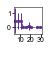

In [10]:
df_toplot_pos = df_toplot_s.copy()
df_toplot_pos['epistasis']=df_toplot_pos['epistasis'].abs()

plt.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.5
fig, ax = plt.subplots(figsize=(0.5,0.5))
plt.tick_params(labelsize=7,length=2.5,pad=0.1)
y = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['epistasis'].mean()
yerr = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['epistasis'].std()
x = df_toplot_pos.groupby(pd.cut(df_toplot_pos['distance'], bins=10))['distance'].mean()
plt.scatter(x,y,color=spot,s=5)
plt.errorbar(x,y,yerr,color=spot,linewidth=1)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.xlabel(' ')
plt.ylabel('')
plt.savefig('images/6261_%s_2ndorder_structure_binned.png'% antigen, transparent=True, dpi=600,bbox_inches='tight')


### permute the distances for null expectation

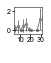

In [11]:
#permute for control
df_toplot_pos = df_toplot_s.copy()
df_toplot_pos['epistasis']=df_toplot_pos['epistasis'].abs()
df_toplot_pos['permuted'] = np.random.permutation(df_toplot_pos['distance'].values)
fig, ax = plt.subplots(figsize=(0.5,0.5))
plt.tick_params(labelsize=7,length=2.5,pad=0.1)
y = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['epistasis'].mean()
yerr = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['epistasis'].std()
x = df_toplot_pos.groupby(pd.cut(df_toplot_pos['permuted'], bins=10))['permuted'].mean()
plt.scatter(x,y,color='gray',s=5)
plt.errorbar(x,y,yerr,color='gray',linewidth=1)
plt.axhline(y=0,linestyle='dashed',c='black',linewidth=0.5)
plt.xlabel(' ')
plt.ylabel('')
plt.savefig('images/6261_%s_2ndorder_structure_binned_permuted.png'% antigen, transparent=True, dpi=600,bbox_inches='tight')
